In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry

Define the paths

In [2]:
master_data_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"
master_meta_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/annotation/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.xml"
master_pod_path  = "/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"

slave_data_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/measurement/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.tiff"
slave_meta_path = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/annotation/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.xml"
slave_pod_path = "/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170416T111343_V20170326T225942_20170328T005942.EOF"


dem_path = "/Users/simon/Data/DEM/srtm_38_01/srtm_38_01_transformed.tif"

"/Users/simon/Data/DEM/srtm_38_01/srtm_38_01_transformed.tif"

Set the view and show the test area 

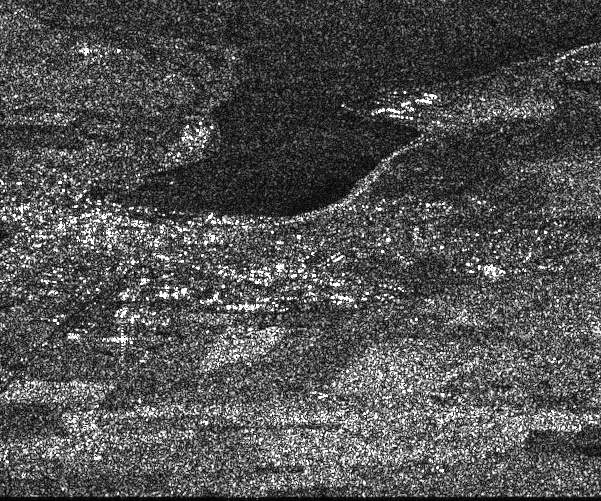

In [3]:
master_view = [1000:1500,5900:6500]
SlcUtil.show_img(Load.slc_data(master_data_path,master_view))

In [4]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [5]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

In [6]:
lut = look_up_table(master_view,meta,precise_orbit,dem);
lut_2 = look_up_table(master_view,meta,precise_orbit,dem,stride=(2,8));

In [7]:
[(key,sum(abs.(lut[key] .- lut_2[key]))/length(elem))  for (key,elem) in lut]

7-element Array{Tuple{String,Float64},1}:
 ("slave_line", 2.091176165230994e-5)  
 ("master_sample", 0.0)                
 ("latitude", 3.112900414709236e-7)    
 ("heights", 0.1958785906177319)       
 ("master_line", 0.0)                  
 ("longitude", 3.441904684853926e-6)   
 ("slave_sample", 4.148365279195567e-6)

In [7]:
## test length
[(key,length(elem)) for (key,elem) in lut]

7-element Array{Tuple{String,Int64},1}:
 ("slave_line", 301101)   
 ("master_sample", 301101)
 ("latitude", 301101)     
 ("heights", 301101)      
 ("master_line", 301101)  
 ("longitude", 301101)    
 ("slave_sample", 301101) 

## Flatening

In [8]:
import Plots
import Colors

In [9]:
c = 299792458
range_pixel_spacing =  c/(2*meta[1]["range_sampling_rate"])
lambda =  c/meta[1]["radar_frequency"]

0.05546576

In [10]:
dr = (lut["master_sample"].-lut["slave_sample"]).*range_pixel_spacing
phi = 4*pi.* dr ./lambda;

In [11]:
dim = (length(master_view[1]),length(master_view[2]))
flat = reshape(exp.(phi .*im),dim);
infero = angle.(flat);

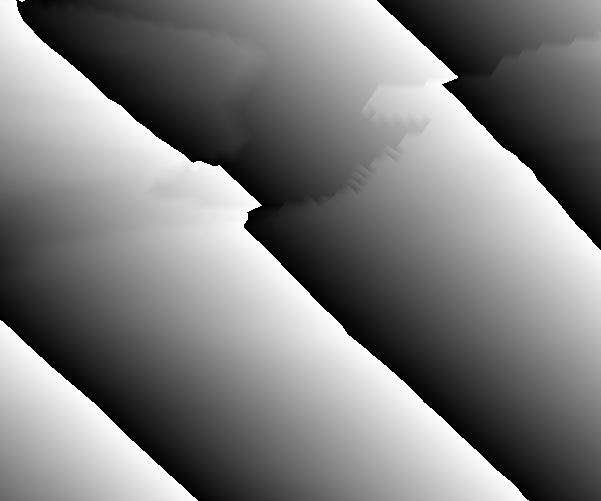

In [12]:
Colors.Gray.((infero .+pi)./ (2* pi))

# !!!! Out dated code below 

In [28]:
flat

501×601 Array{Complex{Float64},2}:
 -0.967952+0.251137im  -0.973183+0.230032im  …      0.471158+0.882049im
  -0.96611+0.258131im  -0.971494+0.237064im         0.488815+0.872388im
 -0.964218+0.265111im  -0.969754+0.244085im         0.506274+0.862373im
 -0.962275+0.272079im  -0.967963+0.251093im         0.523528+0.852009im
 -0.960361+0.278758im  -0.966121+0.258088im         0.540569+0.8413im  
  -0.95846+0.285226im  -0.964229+0.26507im   …      0.557392+0.83025im 
 -0.956516+0.29168im   -0.962287+0.272038im         0.573989+0.818863im
 -0.954528+0.298122im  -0.960293+0.278992im         0.590353+0.807145im
 -0.952496+0.30455im    -0.95825+0.285931im         0.606479+0.7951im  
 -0.950422+0.310964im  -0.956157+0.292856im         0.622359+0.782732im
 -0.948304+0.317365im  -0.954013+0.299766im  …      0.637986+0.770048im
 -0.946142+0.323751im  -0.951812+0.306683im         0.653355+0.757052im
 -0.942189+0.335082im  -0.948386+0.317119im          0.66846+0.743748im
          ⋮                  

## Load meta and pod 

In [10]:
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

In [19]:
a = Misc.flatten(1:4,5:10)

([1, 2, 3, 4, 1, 2, 3, 4, 1, 2  …  3, 4, 1, 2, 3, 4, 1, 2, 3, 4], [5, 5, 5, 5, 6, 6, 6, 6, 7, 7  …  8, 8, 9, 9, 9, 9, 10, 10, 10, 10])

In [24]:
line_padding =3
line_step = 1
sample_padding =3
sample_step = 1

1

In [36]:
master_view_org = master_view ### Corect for other burts TODO
master_line_lut = (master_view_org[1].start-line_padding):line_step:(master_view_org[1].stop+line_padding)
master_sample_lut = (master_view_org[2].start-sample_padding):sample_step:(master_view_org[2].stop+sample_padding)

master_line_lut,master_sample_lut = Misc.flatten(master_line_lut,master_sample_lut)

lut  = Dict{String,Any}()
lut["master_line"] = master_line_lut
lut["master_sample"] = master_sample_lut;

In [37]:
lut

Dict{String,Any} with 2 entries:
  "master_sample" => [5897, 5897, 5897, 5897, 5897, 5897, 5897, 5897, 5897, 589…
  "master_line"   => [997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006  …

### Heights

In [11]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
lat_dem,lon_dem, heights = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

lat_dem,lon_dem, heights = Misc.flatten(lat_dem,lon_dem, heights);
line_sample_dem = to_line_sample(hcat(lat_dem,lon_dem),heights,master_precise_orbit...,master_meta);

In [39]:
lut["heights"] = Misc.interp(line_sample_dem[:,1], line_sample_dem[:,2], heights, 
                            lut["master_line"], lut["master_sample"]);

In [53]:
# Clear space
lat_dem = 0
lon_dem = 0
heights = 0
line_sample_dem = 0

0

In [52]:
lut["heights"]

307749-element Array{Float64,1}:
 40.953998212320755
 45.285766235235144
 49.617534258149526
 53.488926434483695
 54.679262270872975
 55.86959810726226 
 57.05993394365155 
 58.25026978004084 
 59.44060561643012 
 60.6309414528194  
 61.82127728920869 
 63.01161312559798 
 64.20194896198726 
  ⋮                
 81.95745600575133 
 81.80991305649825 
 81.66237010724517 
 81.51482713029262 
 81.36728395989321 
 81.21974078949378 
 81.07219761909437 
 81.0              
 81.0              
 81.0              
 81.0              
 81.0              

 ### Latitude and longitude

In [61]:
lat_lon = to_lat_lon(hcat(lut["master_line"],lut["master_sample"]),lut["heights"],
    master_precise_orbit...,master_meta)
lut["latitude"] = lat_lon[:,1]
lut["longitude"] = lat_lon[:,2]
lat_lon = 0;

### Slave sample Line

In [70]:
line_sample = to_line_sample(hcat(lut["latitude"],lut["longitude"]),lut["heights"],
    slave_precise_orbit...,slave_meta);
lut["slave_line"] = line_sample[:,1]
lut["slave_sample"] = line_sample[:,2]
line_sample = 0;

In [71]:
[(key,length(elem)) for (key,elem) in lut]

7-element Array{Tuple{String,Int64},1}:
 ("slave_line", 307749)   
 ("master_sample", 307749)
 ("latitude", 307749)     
 ("heights", 307749)      
 ("master_line", 307749)  
 ("longitude", 307749)    
 ("slave_sample", 307749) 

In [72]:
[(key,elem[1]) for (key,elem) in lut]

7-element Array{Tuple{String,Real},1}:
 ("slave_line", 997.1741208383277)  
 ("master_sample", 5897)            
 ("latitude", 56.57674028066581)    
 ("heights", 40.953998212320755)    
 ("master_line", 997)               
 ("longitude", 8.32282421483835)    
 ("slave_sample", 5880.316177668783)

In [9]:
stride= (2,1)

(2, 1)

In [15]:
test = collect(1:3:11)

4-element Array{Int64,1}:
  1
  4
  7
 10

In [16]:
append!(test,11)

5-element Array{Int64,1}:
  1
  4
  7
 10
 11

In [17]:
test[end] == 11

true

 Input ideas
 
- master line & sample range
- meta (master,slave)
- pod (master,slave)
- dem (lattitude, longitude, height)

In [23]:
mastes_ranges = [1000:1500,5900:6500]
stride= (2,8)

(2, 8)

In [66]:
using PyCall
scipy_interp = pyimport("scipy.interpolate");

In [67]:
function look_up_table( mastes_ranges,meta,precise_orbit,dem,stride= (1,1))
    
    # initilize lut
    lut  = Dict{String,Any}()
    
    if stride==(1,1)
        master_line_lut,master_sample_lut = Misc.flatten(mastes_ranges[1],mastes_ranges[2])
    else
        line = collect(mastes_ranges[1].start:stride[1]:mastes_ranges[1].stop)
        line[end] = mastes_ranges[1].stop
        sample = collect(mastes_ranges[2].start:stride[2]:mastes_ranges[2].stop)
        sample[end] = mastes_ranges[2].stop
        
        master_line_lut,master_sample_lut = Misc.flatten(line,sample)
    end
    
    
    # Get master line and sample 
    lut["master_line"] = master_line_lut
    lut["master_sample"] = master_sample_lut
    
    # Get heights
    lat_dem,lon_dem, heights = Misc.flatten(dem...)
    dem = 0 # clear memory
    line_sample_dem = to_line_sample(hcat(lat_dem,lon_dem),heights,precise_orbit[1]...,meta[1])
    lut["heights"] = Misc.interp(line_sample_dem[:,1], line_sample_dem[:,2], heights, 
                            lut["master_line"], lut["master_sample"])
    # clear memory
    lat_dem = 0
    lon_dem = 0
    heights = 0
    line_sample_dem = 0
    
    # Get latitude and longitude
    lat_lon = to_lat_lon(hcat(lut["master_line"],lut["master_sample"]),lut["heights"],
    precise_orbit[1]...,meta[1])
    lut["latitude"] = lat_lon[:,1]
    lut["longitude"] = lat_lon[:,2]
    lat_lon = 0 # clear memory
    
    # Get slave line and sample
    line_sample = to_line_sample(hcat(lut["latitude"],lut["longitude"]),lut["heights"],
    precise_orbit[2]...,meta[2]);
    lut["slave_line"] = line_sample[:,1]
    lut["slave_sample"] = line_sample[:,2]
    
    if !(stride==(1,1))
        
        for (key,elem) in lut
            if !(key == "master_sample" || key == "master_line")
                F = scipy_interp.interp2d(sample,line, reshape(lut[key],(length(line),length(sample))))
                lut[key] = reshape(F(collect(master_ranges[2]),collect(master_ranges[1])),:)
            end
        end
        lut["master_line"],lut["master_sample"] = Misc.flatten(mastes_ranges[1],mastes_ranges[2])
    
    end
    

    return lut
end

look_up_table (generic function with 2 methods)

### Test the function 

In [68]:
master_view = [1000:1500,5900:6500]

2-element Array{UnitRange{Int64},1}:
 1000:1500
 5900:6500

In [69]:
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);



In [70]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

In [71]:
lut_1 = look_up_table( mastes_ranges,meta,precise_orbit,dem)

Dict{String,Any} with 7 entries:
  "slave_line"    => [1000.17, 1001.17, 1002.17, 1003.17, 1004.17, 1005.17, 100…
  "master_sample" => [5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 590…
  "latitude"      => [56.5764, 56.5763, 56.5762, 56.576, 56.5759, 56.5758, 56.5…
  "heights"       => [51.5666, 52.713, 53.8594, 55.0058, 56.1776, 57.368, 58.55…
  "master_line"   => [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 100…
  "longitude"     => [8.32236, 8.3223, 8.32224, 8.32219, 8.32213, 8.32207, 8.32…
  "slave_sample"  => [5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 588…

In [72]:
lut_2 = look_up_table( mastes_ranges,meta,precise_orbit,dem,(2,8))

Dict{String,Any} with 7 entries:
  "slave_line"    => [1000.17, 1001.17, 1002.17, 1003.17, 1004.17, 1005.17, 100…
  "master_sample" => [5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 590…
  "latitude"      => [56.5764, 56.5763, 56.5762, 56.576, 56.5759, 56.5758, 56.5…
  "heights"       => [51.5666, 52.713, 53.8594, 55.0185, 56.1776, 57.368, 58.55…
  "master_line"   => [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 100…
  "longitude"     => [8.32236, 8.3223, 8.32224, 8.32219, 8.32213, 8.32207, 8.32…
  "slave_sample"  => [5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 588…

In [76]:
[(key,sum(abs.(lut_1[key] .- lut_2[key]))/length(elem))  for (key,elem) in lut_1]

7-element Array{Tuple{String,Float64},1}:
 ("slave_line", 2.091176165230994e-5)  
 ("master_sample", 0.0)                
 ("latitude", 3.112900414709236e-7)    
 ("heights", 0.1958785906177319)       
 ("master_line", 0.0)                  
 ("longitude", 3.441904684853926e-6)   
 ("slave_sample", 4.148365279195567e-6)

In [33]:
Misc.flatten(master_view[1],master_view[2]);

In [34]:
using PyCall
scipy_interp = pyimport("scipy.interpolate");

In [46]:
stride = (2,8)
master_ranges = [1000:1500,5900:6500]

2-element Array{UnitRange{Int64},1}:
 1000:1500
 5900:6500

In [53]:
# initilize lut
    lut  = Dict{String,Any}()
    
    if stride==(1,1)
        master_line_lut,master_sample_lut = Misc.flatten(mastes_ranges[1],mastes_ranges[2])
    else
        line = collect(mastes_ranges[1].start:stride[1]:mastes_ranges[1].stop)
        line[end] = mastes_ranges[1].stop
        sample = collect(mastes_ranges[2].start:stride[2]:mastes_ranges[2].stop)
        sample[end] = mastes_ranges[2].stop
        
        master_line_lut,master_sample_lut = Misc.flatten(line,sample);
    end

([1000, 1002, 1004, 1006, 1008, 1010, 1012, 1014, 1016, 1018  …  1482, 1484, 1486, 1488, 1490, 1492, 1494, 1496, 1498, 1500], [5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900  …  6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500])

In [54]:
   # Get master line and sample 
    lut["master_line"] = master_line_lut
    lut["master_sample"] = master_sample_lut
    
    # Get heights
    lat_dem,lon_dem, heights = Misc.flatten(dem...)
    dem = 0 # clear memory
    line_sample_dem = to_line_sample(hcat(lat_dem,lon_dem),heights,precise_orbit[1]...,meta[1])
    lut["heights"] = Misc.interp(line_sample_dem[:,1], line_sample_dem[:,2], heights, 
                            lut["master_line"], lut["master_sample"])
    # clear memory
    
    # Get latitude and longitude
    lat_lon = to_lat_lon(hcat(lut["master_line"],lut["master_sample"]),lut["heights"],
    precise_orbit[1]...,meta[1])
    lut["latitude"] = lat_lon[:,1]
    lut["longitude"] = lat_lon[:,2]
   
    # Get slave line and sample
    line_sample = to_line_sample(hcat(lut["latitude"],lut["longitude"]),lut["heights"],
    precise_orbit[2]...,meta[2]);
    lut["slave_line"] = line_sample[:,1]
    lut["slave_sample"] = line_sample[:,2];

In [56]:
F = scipy_interp.interp2d(sample,line, reshape(lut["heights"],(length(line),length(sample))))
heigts = reshape(F(collect(master_ranges[2]),collect(master_ranges[1])),:)

301101-element Array{Float64,1}:
 51.56655308798861 
 52.71297302085862 
 53.85939295372863 
 55.018518315610706
 56.177643677492775
 57.36797951388206 
 58.55831535027134 
 59.748651186660624
 60.93898702304991 
 62.1293228594392  
 63.31965869582848 
 64.27556952922811 
 65.23148036262772 
  ⋮                
 82.0              
 82.0              
 81.96961644161934 
 81.93923288323867 
 81.7916899339856  
 81.64414698473252 
 81.49660403547944 
 81.34906108622634 
 81.20151814034114 
 81.05397519445593 
 81.02698759722796 
 81.0              

In [49]:
dem

0

In [63]:
for (key,elem) in lut
    if !(key == "master_sample" || key == "master_line")
        F = scipy_interp.interp2d(sample,line, reshape(lut[key],(length(line),length(sample))))
        lut[key] = reshape(F(collect(master_ranges[2]),collect(master_ranges[1])),:)
    end
end
lut["master_line"],lut["master_sample"] = Misc.flatten(mastes_ranges[1],mastes_ranges[2])

([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009  …  1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500], [5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900  …  6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500, 6500])

In [64]:
lut

Dict{String,Any} with 7 entries:
  "slave_line"    => [1000.17, 1001.17, 1002.17, 1003.17, 1004.17, 1005.17, 100…
  "master_sample" => [5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 5900, 590…
  "latitude"      => [56.5764, 56.5763, 56.5762, 56.576, 56.5759, 56.5758, 56.5…
  "heights"       => [51.5666, 52.713, 53.8594, 55.0185, 56.1776, 57.368, 58.55…
  "master_line"   => [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 100…
  "longitude"     => [8.32236, 8.3223, 8.32224, 8.32219, 8.32213, 8.32207, 8.32…
  "slave_sample"  => [5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 5883.32, 588…

In [65]:
[(key,length(elem)) for (key,elem) in lut]

7-element Array{Tuple{String,Int64},1}:
 ("slave_line", 301101)   
 ("master_sample", 301101)
 ("latitude", 301101)     
 ("heights", 301101)      
 ("master_line", 301101)  
 ("longitude", 301101)    
 ("slave_sample", 301101) 

In [57]:
test = "master_sample"

"master_sample"

In [61]:
!(test == "master_sample" || test == "master_line")

false

In [9]:
[(key,length(elem)) for (key,elem) in lut]

7-element Array{Tuple{String,Int64},1}:
 ("slave_line", 307749)   
 ("master_sample", 307749)
 ("latitude", 307749)     
 ("heights", 307749)      
 ("master_line", 307749)  
 ("longitude", 307749)    
 ("slave_sample", 307749) 

In [10]:
[(key,elem[1]) for (key,elem) in lut]

7-element Array{Tuple{String,Real},1}:
 ("slave_line", 997.1741208383277)  
 ("master_sample", 5897)            
 ("latitude", 56.57674028066581)    
 ("heights", 40.953998212320755)    
 ("master_line", 997)               
 ("longitude", 8.32282421483835)    
 ("slave_sample", 5880.316177668783)

In [11]:
mastes_ranges = (mastes_ranges[1] .+ 2, mastes_ranges[2] .-4)

(999:1:1505, 5893:1:6499)

In [12]:
@time look_up_table( mastes_ranges,meta,precise_orbit,dem)

  7.502842 seconds (119.43 M allocations: 9.228 GiB, 15.98% gc time)


Dict{String,Any} with 7 entries:
  "slave_line"    => [999.174, 1000.17, 1001.17, 1002.17, 1003.17, 1004.17, 100…
  "master_sample" => [5893, 5893, 5893, 5893, 5893, 5893, 5893, 5893, 5893, 589…
  "latitude"      => [56.5765, 56.5764, 56.5762, 56.5761, 56.576, 56.5759, 56.5…
  "heights"       => [43.0391, 47.3708, 51.7026, 56.0344, 59.8234, 61.0138, 62.…
  "master_line"   => [999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008…
  "longitude"     => [8.32293, 8.32282, 8.32271, 8.32259, 8.32249, 8.32243, 8.3…
  "slave_sample"  => [5876.32, 5876.32, 5876.32, 5876.32, 5876.32, 5876.32, 587…